## Goal

- reproduce the final performance plot for all the methods

## TODO

- [x] setup bootstrapping performance
- [x] investigate FactorNet relatively poor performance

## Geral notes

- Class imbalance ratios:
  - genome-wide: .1%-1%
  - accessible regions: 1%-10%

In [25]:
import kipoi
import os
import sys
import pandas as pd
from config import SINGLE_TASK_MODELS, get_dl_kwargs, TF2CT
from kipoi.readers import HDF5Reader
from concise.eval_metrics import auprc, auc, accuracy
from collections import OrderedDict
import seaborn as sns
from pybedtools import BedTool
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from m_kipoi.metrics import classification_metrics, MetricsTupleList, BootstrapMetric
from m_kipoi.exp.tfbinding.data import get_eval_predictions, get_DeepSEA_idx
from m_kipoi.exp.tfbinding.eval import eval_model

In [23]:
root_dir = '../../../'
eval_dir = root_dir + 'data/processed/tfbinding/eval/preds'
matrics_dir = root_dir + 'data/processed/tfbinding/eval/metrics'
plot_dir = root_dir + 'data/processed/tfbinding/eval/plots'

In [3]:
ls {eval_dir}

../../../data/processed/tfbinding/eval/preds@


In [4]:
tf = 'CEBPB'
model = 'DeepBind'

In [5]:
MODELS = list({m for tf, v in SINGLE_TASK_MODELS.items() for m in v})
TFS = set(SINGLE_TASK_MODELS)

In [6]:
MODELS = ['pwm_HOCOMOCO', 'DeepBind', 'lsgkm-SVM', 'DeepSEA', 'FactorNet']

In [14]:
n = pd.Series(kipoi.get_model_descr("DeepSEA/predict").schema.targets.column_labels)

2018-05-02 19:13:53,971 [INFO] Update /users/avsec/.kipoi/models/


In [15]:
get_DeepSEA_idx("JUND", "HepG2")

560

In [16]:
n.str.contains("JUND", case=False).sum()

8

In [18]:
eval_model("JUND", "FactorNet", metrics)

OrderedDict([('tf', 'JUND'),
             ('model', 'FactorNet'),
             ('filter_dnase', False),
             ('auPR', 0.5232955257793761),
             ('auROC', 0.9970828071711202),
             ('accuracy', 0.9855886338998443),
             ('n_positive', 4667),
             ('n_negative', 1433434),
             ('frac_positive', 0.0032452518981629245)])

In [19]:
# Not boostrapped version
df = pd.DataFrame(Parallel(n_jobs=32)(delayed(eval_model)(tf, model, metrics, filter_dnase=filter_dnase) 
                                      for model in tqdm(MODELS)
                                      for tf in tqdm(TFS)
                                      for filter_dnase in [True, False]))

100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Exception occuredException occured<class 'OSError'>

<class 'OSError'>



In [20]:
# Make a nice column description
df['dataset'] = "Chromosome wide (chr8))"
df['dataset'][df.filter_dnase==True] = "Only accessible regions (chr8))"

/users/avsec/bin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


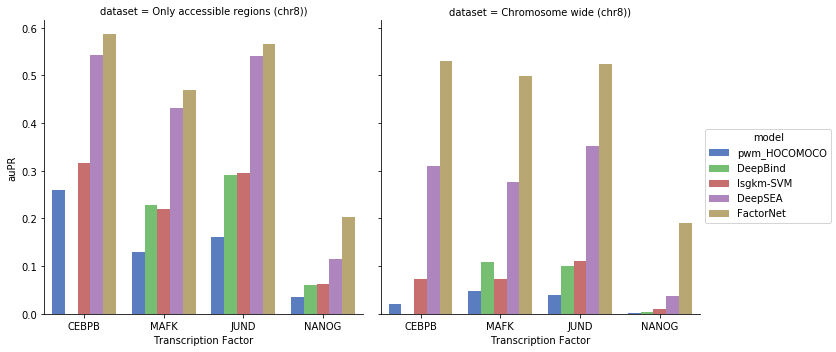

In [21]:
g = sns.factorplot(x="tf", y="auPR", hue="model", data=df,
                   col="dataset",
                   size=5, kind="bar", palette="muted")
g.set_xlabels("Transcription Factor");

In [22]:
from plotnine import *

/users/avsec/bin/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


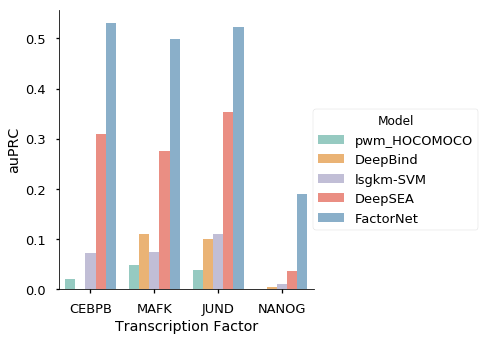

In [85]:
sns.set_context("talk")
pallete = ['#8dd3c7','#fdb462','#bebada','#fb8072','#80b1d3']
#pallete = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854']
#pallete = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0']
df = df.rename(columns={"model": "Model"})
g = sns.factorplot(x="tf", y="auPR", hue="Model", data=df[~df.filter_dnase],
                   size=5, kind="bar", palette=pallete)
#g.despine(left=True)
#plt.legend(loc='upper right', bbox_to_anchor=(1.4,1))
g.set_xlabels("Transcription Factor");
g.set_ylabels("auPRC");

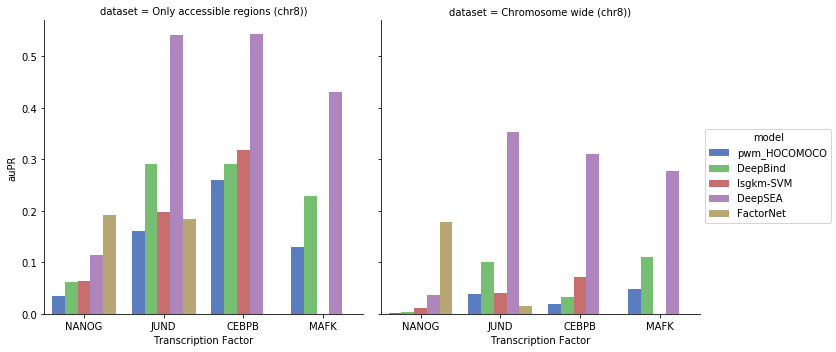

In [22]:
g = sns.factorplot(x="tf", y="auPR", hue="model", data=df,
                   col="dataset",
                   size=5, kind="bar", palette="muted")
g.set_xlabels("Transcription Factor");

## Bootstrap the performance metric

In [51]:
def flatten_list(l):
    return [y for x in l for y in x]

In [52]:
# boostrapped version
df = pd.DataFrame(flatten_list(Parallel(n_jobs=32)(delayed(eval_model)(tf, model, metrics, n_bootstrap=100, filter_dnase=filter_dnase) 
                                                   for model in tqdm(MODELS)
                                                   for tf in tqdm(TFS)
                                                   for filter_dnase in [True, False])))

100%|██████████| 4/4 [00:00<00:00, 10.04it/s]


Exception occuredException occuredException occured


Exception occured<class 'OSError'><class 'OSError'><class 'OSError'>



<class 'OSError'>


In [67]:
# Make a nice column description
df['dataset'] = "Chromosome wide (chr8)"
df['dataset'][df.filter_dnase==True] = "Only accessible regions (chr8)"

/users/avsec/bin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


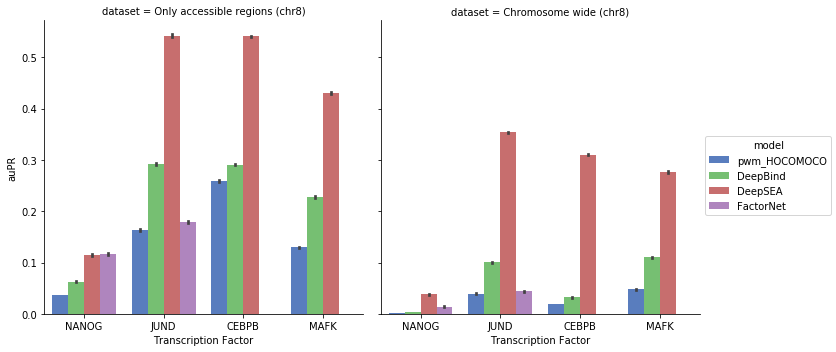

In [70]:
g = sns.factorplot(x="tf", y="auPR", hue="model", data=df,
                   col="dataset",
                   size=5, kind="bar", palette="muted")
g.set_xlabels("Transcription Factor");

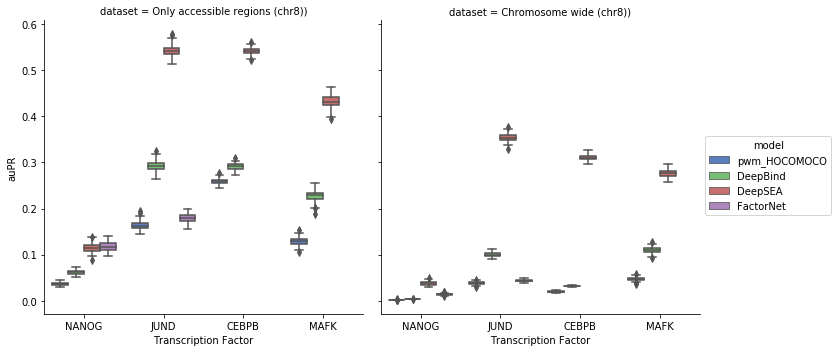

In [66]:
g = sns.factorplot(x="tf", y="auPR", hue="model", data=df,
                   col="dataset",
                   size=5, kind="box", palette="muted")
g.set_xlabels("Transcription Factor");

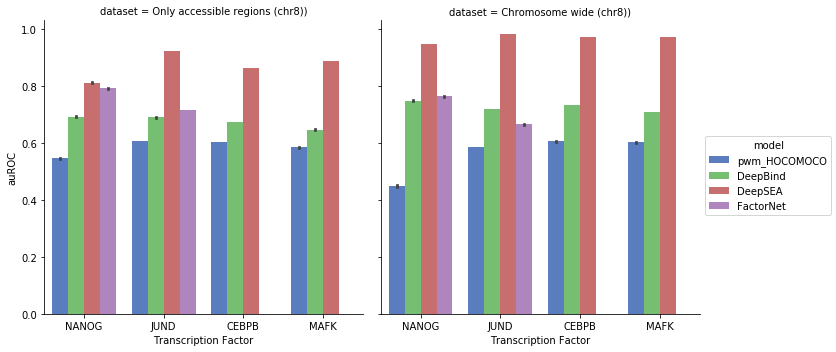

In [58]:
g = sns.factorplot(x="tf", y="auROC", hue="model", data=df,
                   col="dataset",
                   size=5, kind="bar", palette="muted")
g.set_xlabels("Transcription Factor");

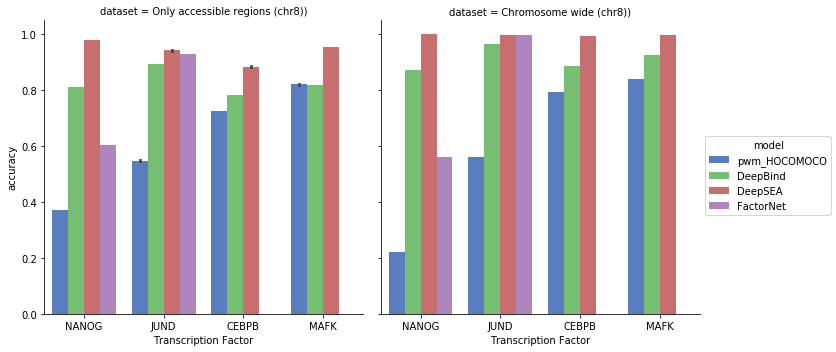

In [59]:
g = sns.factorplot(x="tf", y="accuracy", hue="model", data=df,
                   col="dataset",
                   size=5, kind="bar", palette="muted")
g.set_xlabels("Transcription Factor");

## Add models trained from scratch

In [122]:
df[df.tf=="JUND"]

,tf,model,auPR,auROC,accuracy
3,JUND,pwm_HOCOMOCO,0.039243,0.584844,0.562419
7,JUND,DeepBind,0.100298,0.718540,0.964003
11,JUND,DeepSEA,0.352839,0.981223,0.996890
15,JUND,FactorNet,0.043374,0.664716,0.996584


In [6]:
data=[
    {'TF':"JUND","Model":"PWM (101bp)",'AUPRC':.039},
    {'TF':"JUND","Model":"DeepBind (101bp)",'AUPRC':.1},
    {'TF':"JUND","Model":"DeepSEA (1000bp)",'AUPRC':.353},
    {'TF':"JUND","Model":"Seq_only (1000bp)",'AUPRC':.422},
    {'TF':"JUND","Model":"Seq-DNAse (101bp)",'AUPRC':.279},
    {'TF':"JUND","Model":"Seq-DNAse (101bp)",'AUPRC':.289},
    {'TF':"JUND","Model":"Seq-DNAse (101bp)",'AUPRC':.293},
    {'TF':"JUND","Model":"Seq-DNAse (101bp)",'AUPRC':.294},
    {'TF':"JUND","Model":"Seq-DNAse (1000bp)",'AUPRC':.600},
]
    
df_JUND=pd.DataFrame(data)

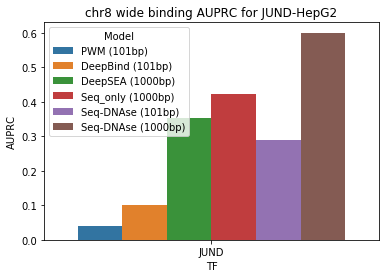

In [7]:
ax=sns.barplot(x='TF',y='AUPRC',hue='Model', ci=None, data=df_JUND)
ax.set_title('chr8 wide binding AUPRC for JUND-HepG2')
fig=ax.get_figure()

## Get the execution time

In [ ]:
import `b


In [74]:
from glob import glob

In [115]:
# Runtime for batch_size=256
df= pd.concat([pd.read_json(x) for x in glob(os.path.join(root_dir, "data/processed/tfbinding/eval/runtimes/*/*.256.json"))])

In [116]:
df.groupby('model').apply(lambda group: group.times.iloc[1:].mean())

model
DeepBind/D00776.005                 0.002374
DeepSEA/predict                     0.093671
FactorNet/JUND/meta_Unique35_DGF    0.118314
pwm_HOCOMOCO/human/JUND             0.001245
dtype: float64

In [102]:
df

model  \
model                                                                  
DeepBind/D00776.005              1               DeepBind/D00776.005   
                                 2               DeepBind/D00776.005   
                                 3               DeepBind/D00776.005   
                                 4               DeepBind/D00776.005   
                                 5               DeepBind/D00776.005   
                                 6               DeepBind/D00776.005   
                                 7               DeepBind/D00776.005   
                                 8               DeepBind/D00776.005   
                                 9               DeepBind/D00776.005   
DeepSEA/predict                  1                   DeepSEA/predict   
                                 2                   DeepSEA/predict   
                                 3                   DeepSEA/predict   
                                 4                   DeepSEA/predict   
                                 5                   DeepSEA/predict   
                                 6                   DeepSEA/predict   
                                 7                   DeepSEA/predict   
                                 8                   DeepSEA/predict   
                                 9                   DeepSEA/predict   
FactorNet/JUND/meta_Unique35_DGF 1  FactorNet/JUND/meta_Unique35_DGF   
                                 2  FactorNet/JUND/meta_Unique35_DGF   
                                 3  FactorNet/JUND/meta_Unique35_DGF   
                                 4  FactorNet/JUND/meta_Unique35_DGF   
                                 5  FactorNet/JUND/meta_Unique35_DGF   
                                 6  FactorNet/JUND/meta_Unique35_DGF   
                                 7  FactorNet/JUND/meta_Unique35_DGF   
                                 8  FactorNet/JUND/meta_Unique35_DGF   
                                 9  FactorNet/JUND/meta_Unique35_DGF   
pwm_HOCOMOCO/human/JUND          1           pwm_HOCOMOCO/human/JUND   
                                 2           pwm_HOCOMOCO/human/JUND   
                                 3           pwm_HOCOMOCO/human/JUND   
                                 4           pwm_HOCOMOCO/human/JUND   
                                 5           pwm_HOCOMOCO/human/JUND   
                                 6           pwm_HOCOMOCO/human/JUND   
                                 7           pwm_HOCOMOCO/human/JUND   
                                 8           pwm_HOCOMOCO/human/JUND   
                                 9           pwm_HOCOMOCO/human/JUND   

                                     model_group  num_runs    tf     times  
model                                                                       
DeepBind/D00776.005              1      DeepBind        10  JUND  0.002789  
                                 2      DeepBind        10  JUND  0.002411  
                                 3      DeepBind        10  JUND  0.002316  
                                 4      DeepBind        10  JUND  0.002383  
                                 5      DeepBind        10  JUND  0.002301  
                                 6      DeepBind        10  JUND  0.002330  
                                 7      DeepBind        10  JUND  0.002191  
                                 8      DeepBind        10  JUND  0.002334  
                                 9      DeepBind        10  JUND  0.002315  
DeepSEA/predict                  1       DeepSEA        10  JUND  0.096747  
                                 2       DeepSEA        10  JUND  0.094936  
                                 3       DeepSEA        10  JUND  0.093097  
                                 4       DeepSEA        10  JUND  0.093293  
                                 5       DeepSEA        10  JUND  0.093484  
                                 6       DeepSEA        10  JUND  0.093145  
                 

In [84]:
glob(os.path.join(root_dir, "data/processed/tfbinding/eval/runtimes/*/*.json"))

['../../../data/processed/tfbinding/eval/runtimes/JUND/pwm_HOCOMOCO.256.json',
 '../../../data/processed/tfbinding/eval/runtimes/JUND/DeepBind.256.json',
 '../../../data/processed/tfbinding/eval/runtimes/JUND/FactorNet.256.json',
 '../../../data/processed/tfbinding/eval/runtimes/JUND/DeepSEA.256.json']

In [76]:
df

[]

## Compute summaries

In [145]:
a = BedTool(os.path.join(root_dir, intervals_file))

In [148]:
dfi = pd.DataFrame([{"start": i.start, "end": i.stop} for i in b])

(0, 1000)

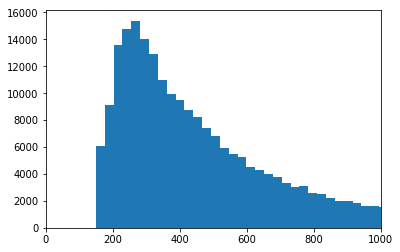

In [98]:
plt.hist(dfi.end - dfi.start, bins=100);
plt.xlim([0, 1000])

In [99]:
interval = out[0]

In [100]:
df_filtered = pd.read_csv(out.fn, sep="\t", header=None)
df_filtered.columns = ['chr', 'start', 'end', 'cls']

In [101]:
df_filtered.cls.mean()

0.04820564389416127

In [102]:
df_unfiltered = pd.read_csv(os.path.join(root_dir, intervals_file), sep="\t", header=None)
df_unfiltered.columns = ['chr', 'start', 'end', 'cls']

In [103]:
df_unfiltered.cls.mean()

0.0022487989369314116

In [116]:
df_filtered['filtered`'] = True

In [125]:
np.sum(df_unfiltered.merge(df_filtered, how='left', on=list(df_unfiltered.columns)).filtered==True)

31822

In [18]:
# Only 1.6% is covered
24073/1438101

0.016739436242656114